In [2]:
!pip install pandas numpy scikit-learn matplotlib seaborn imblearn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance
import warnings
import os
import pickle
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

class DelinquencyPredictorLR:
    """
    A logistic regression-based model for predicting delinquency.
    Supports binary classification (delinquent/not delinquent).
    
    Attributes:
        model: LogisticRegression model (initialized in build_model).
        scaler: StandardScaler for feature scaling (initialized in train_model).
        label_encoders: Dictionary of LabelEncoder objects for categorical columns (set in load_and_preprocess_data).
        feature_names: List of feature names after preprocessing (set in load_and_preprocess_data).
        task_type: String indicating task ('classification').
    """
    
    def __init__(self, task_type='classification'):
        """
        Initialize the DelinquencyPredictorLR.

        Args:
            task_type (str): Task type ('classification'). Default: 'classification'.
        """
        self.model = None
        self.scaler = None
        self.label_encoders = {}
        self.feature_names = None
        self.task_type = task_type
        print(f"Initialized DelinquencyPredictorLR for {task_type} task")

In [5]:
def load_and_preprocess_data(self, file_path=None, data=None):
    """
    Load and preprocess the dataset for training or prediction.

    Args:
        file_path (str, optional): Path to CSV file containing the dataset.
        data (pd.DataFrame, optional): DataFrame containing the dataset.

    Returns:
        tuple: (X_processed.values, y) where X_processed.values is the preprocessed feature matrix (numpy array)
               and y is the target array (numpy array).
    """
    print("Loading dataset...")
    
    if data is not None:
        df = data
        print(f"Dataset provided directly. Shape: {df.shape}")
    elif file_path and os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path)
            print(f"Dataset loaded successfully. Shape: {df.shape}")
        except Exception as e:
            print(f"Error loading file: {e}")
            print("Creating sample dataset instead...")
            df = self.create_sample_dataset()
    else:
        print("No file path or data provided. Creating sample dataset...")
        df = self.create_sample_dataset()
    
    print("\n" + "="*50)
    print("DATASET INFORMATION")
    print("="*50)
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nData types:")
    print(df.dtypes)
    print(f"\nMissing values:\n{df.isnull().sum()}")
    
    print("\nHandling missing values...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
    
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    if 'Delinquent_Account' in df.columns and self.task_type == 'classification':
        target_col = 'Delinquent_Account'
        print(f"Using 'Delinquent_Account' as target for classification")
    else:
        raise ValueError("Delinquent_Account column required for classification")
    
    y = df[target_col].values
    X = df.drop([target_col, 'Customer_ID'], axis=1)
    
    # Apply one-hot encoding
    X_processed = pd.get_dummies(X, columns=['Location', 'Credit_Card_Type', 'Employment_Status'], prefix=['Location', 'Card', 'Emp'])
    
    # Encode categorical payment history columns
    categorical_columns = ['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6']
    for column in categorical_columns:
        print(f"Encoding categorical column: {column}")
        le = LabelEncoder()
        X_processed[column] = le.fit_transform(X_processed[column])
        self.label_encoders[column] = le
    
    # Set feature_names after all preprocessing
    self.feature_names = X_processed.columns.tolist()
    print(f"Features: {self.feature_names}")
    print(f"Number of features: {len(self.feature_names)}")
    print(f"X_processed shape: {X_processed.shape}")
    
    if len(self.feature_names) != X_processed.shape[1]:
        raise ValueError(f"Feature names length ({len(self.feature_names)}) does not match X_processed columns ({X_processed.shape[1]})")
    
    print(f"Encoded {len(categorical_columns)} categorical columns")
    print(f"Target distribution: {np.bincount(y)}")
    
    return X_processed.values, y

# Add method to class
DelinquencyPredictorLR.load_and_preprocess_data = load_and_preprocess_data

# Load and preprocess data
predictor_lr = DelinquencyPredictorLR(task_type='classification')
data = pd.read_csv('Delinquency_prediction_dataset.csv')  # Update path
X, y = predictor_lr.load_and_preprocess_data(data=data)

Initialized DelinquencyPredictorLR for classification task
Loading dataset...
Dataset provided directly. Shape: (500, 20)

DATASET INFORMATION
Shape: (500, 20)
Columns: ['Customer_ID', 'Age', 'Income', 'Credit_Score', 'Credit_Utilization', 'Missed_Payments', 'Delinquent_Account', 'Loan_Balance', 'Debt_to_Income_Ratio', 'Employment_Status', 'Account_Tenure', 'Credit_Card_Type', 'Location', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Unnamed: 19']

Data types:
Customer_ID              object
Age                       int64
Income                  float64
Credit_Score            float64
Credit_Utilization      float64
Missed_Payments           int64
Delinquent_Account        int64
Loan_Balance            float64
Debt_to_Income_Ratio    float64
Employment_Status        object
Account_Tenure            int64
Credit_Card_Type         object
Location                 object
Month_1                  object
Month_2                  object
Month_3                  object
Mo

In [6]:
def create_sample_dataset(self, n_samples=5000):
    """
    Create a synthetic dataset for testing when no real dataset is provided.

    Args:
        n_samples (int): Number of samples to generate. Default: 5000.

    Returns:
        pd.DataFrame: Synthetic dataset with financial features and 'Delinquent_Account' target.
    """
    print("Creating sample dataset with realistic financial features...")
    
    np.random.seed(42)
    
    data = {
        'Customer_ID': range(n_samples),
        'Age': np.random.randint(18, 80, n_samples),
        'Income': np.random.lognormal(10.5, 0.8, n_samples),
        'Credit_Score': np.random.normal(650, 100, n_samples).astype(int),
        'Credit_Utilization': np.random.beta(2, 5, n_samples),
        'Missed_Payments': np.random.poisson(0.3, n_samples),
        'Loan_Balance': np.random.lognormal(9.5, 0.7, n_samples),
        'Debt_to_Income_Ratio': np.random.beta(2, 5, n_samples),
        'Employment_Status': np.random.choice(['Employed', 'Unemployed', 'Self-Employed'], n_samples, p=[0.8, 0.1, 0.1]),
        'Account_Tenure': np.random.exponential(5, n_samples),
        'Credit_Card_Type': np.random.choice(['Standard', 'Premium', 'Basic'], n_samples),
        'Location': np.random.choice(['Chicago', 'New_York', 'Los_Angeles'], n_samples),
        'Month_1': np.random.choice(['On-time', 'Late', 'Missed'], n_samples, p=[0.8, 0.15, 0.05]),
        'Month_2': np.random.choice(['On-time', 'Late', 'Missed'], n_samples, p=[0.8, 0.15, 0.05]),
        'Month_3': np.random.choice(['On-time', 'Late', 'Missed'], n_samples, p=[0.8, 0.15, 0.05]),
        'Month_4': np.random.choice(['On-time', 'Late', 'Missed'], n_samples, p=[0.8, 0.15, 0.05]),
        'Month_5': np.random.choice(['On-time', 'Late', 'Missed'], n_samples, p=[0.8, 0.15, 0.05]),
        'Month_6': np.random.choice(['On-time', 'Late', 'Missed'], n_samples, p=[0.8, 0.15, 0.05]),
    }
    
    df = pd.DataFrame(data)
    
    df['Credit_Score'] = np.clip(df['Credit_Score'], 300, 850)
    df['Account_Tenure'] = np.clip(df['Account_Tenure'], 0, 30)
    
    risk_score = (
        0.3 * (1 - (df['Credit_Score'] - 300) / 550) +
        0.2 * df['Debt_to_Income_Ratio'] +
        0.2 * df['Credit_Utilization'] +
        0.2 * df['Missed_Payments'] +
        0.1 * (df['Employment_Status'] == 'Unemployed').astype(int)
    )
    
    df['Delinquent_Account'] = (risk_score + np.random.normal(0, 0.1, n_samples) > 0.7).astype(int)
    
    print(f"Sample dataset created with {n_samples} rows and {len(df.columns)} columns")
    print(f"Target distribution: {np.bincount(df['Delinquent_Account'])}")
    
    return df

# Add method to class
DelinquencyPredictorLR.create_sample_dataset = create_sample_dataset

In [7]:
def build_model(self, input_dim):
    """
    Build a LogisticRegression model.

    Args:
        input_dim (int): Number of input features.

    Returns:
        LogisticRegression: Configured logistic regression model.
    """
    print(f"\nBuilding logistic regression model...")
    print(f"Input dimension: {input_dim}")
    
    model = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )
    
    print("\nModel Configuration:")
    print(model)
    
    return model

# Add method to class
DelinquencyPredictorLR.build_model = build_model

In [8]:
def train_model(self, X, y, test_size=0.2, use_smote=False):
    """
    Train the logistic regression model.

    Args:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target array.
        test_size (float): Fraction of data for test set. Default: 0.2.
        use_smote (bool): Whether to apply SMOTE to balance training data. Default: False.

    Returns:
        dict: Training history with train/test accuracy.
    """
    print(f"\n{'='*50}")
    print("TRAINING THE MODEL")
    print("="*50)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    
    # Apply SMOTE if enabled
    if use_smote:
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=42, k_neighbors=10, sampling_strategy=0.75)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print(f"SMOTE applied. New training samples: {len(X_train)}, Target distribution: {np.bincount(y_train)}")
    
    # Scale features
    print("Scaling features...")
    self.scaler = StandardScaler()
    X_train_scaled = self.scaler.fit_transform(X_train)
    X_test_scaled = self.scaler.transform(X_test)
    
    print(f"Feature scaling completed. Train mean: {X_train_scaled.mean():.3f}, Std: {X_train_scaled.std():.3f}")
    
    # Build and train model
    self.model = self.build_model(X_train_scaled.shape[1])
    self.model.fit(X_train_scaled, y_train)
    
    # Compute train/test accuracy
    train_accuracy = accuracy_score(y_train, self.model.predict(X_train_scaled))
    test_accuracy = accuracy_score(y_test, self.model.predict(X_test_scaled))
    
    history = {
        'train_accuracy': [train_accuracy],
        'test_accuracy': [test_accuracy]
    }
    
    print(f"\nTraining completed!")
    print(f"Train accuracy: {train_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    
    return history, X_train, X_test, y_train, y_test

# Add method to class
DelinquencyPredictorLR.train_model = train_model

# Split data and train
history, X_train, X_test, y_train, y_test = predictor_lr.train_model(X, y, test_size=0.2, use_smote=True)


TRAINING THE MODEL
Training samples: 400
Test samples: 100
SMOTE applied. New training samples: 588, Target distribution: [336 252]
Scaling features...
Feature scaling completed. Train mean: 0.000, Std: 0.984

Building logistic regression model...
Input dimension: 31

Model Configuration:
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

Training completed!
Train accuracy: 0.6650
Test accuracy: 0.5200


In [9]:
### Cell 6: `evaluate_model`

def evaluate_model(self, X_test, y_test, threshold=0.3):
    """
    Evaluate the model on a test set.

    Args:
        X_test (np.ndarray): Test feature matrix.
        y_test (np.ndarray): Test target array.
        threshold (float): Probability threshold for classification. Default: 0.3.

    Returns:
        tuple: (metrics, y_pred_proba) where metrics is a dictionary of evaluation metrics
               and y_pred_proba is the predicted probabilities.
    """
    print(f"\n{'='*50}")
    print("MODEL EVALUATION")
    print("="*50)
    
    X_test_scaled = self.scaler.transform(X_test)
    
    y_pred_proba = self.model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_pred_proba > threshold).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc
    }
    
    print("Classification Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    return metrics, y_pred_proba

# Add method to class
DelinquencyPredictorLR.evaluate_model = evaluate_model

# Evaluate model
metrics, y_pred_proba = predictor_lr.evaluate_model(X_test, y_test, threshold=0.3)


MODEL EVALUATION
Classification Metrics:
Accuracy: 0.3100
Precision: 0.1646
Recall: 0.8125
F1-Score: 0.2737
AUC-ROC: 0.4844

Confusion Matrix:
[[18 66]
 [ 3 13]]


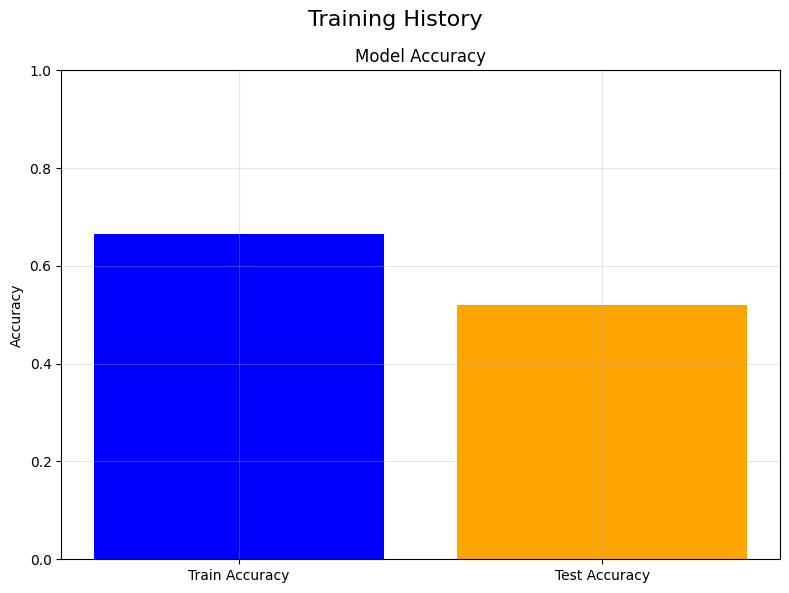

In [10]:

def plot_training_history(self, history):
    """
    Plot training and test accuracy.

    Args:
        history (dict): Training history with train/test accuracy.
    """
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.suptitle('Training History', fontsize=16)
    
    ax.bar(['Train Accuracy', 'Test Accuracy'], 
           [history['train_accuracy'][0], history['test_accuracy'][0]],
           color=['blue', 'orange'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Accuracy')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Add method to class
DelinquencyPredictorLR.plot_training_history = plot_training_history

# Plot training history
predictor_lr.plot_training_history(history)

In [11]:
def save_model(self, model_path="delinquency_model_lr.pkl"):
    """
    Save the trained model and preprocessing pipeline.

    Args:
        model_path (str): Path to save the model. Default: 'delinquency_model_lr.pkl'.
    """
    pipeline_data = {
        'model': self.model,
        'scaler': self.scaler,
        'label_encoders': self.label_encoders,
        'feature_names': self.feature_names,
        'task_type': self.task_type
    }
    
    with open(model_path, 'wb') as f:
        pickle.dump(pipeline_data, f)
    
    print(f"Model and pipeline saved to: {model_path}")

# Add method to class
DelinquencyPredictorLR.save_model = save_model

# Save model
predictor_lr.save_model("delinquency_model_lr.pkl")

Model and pipeline saved to: delinquency_model_lr.pkl


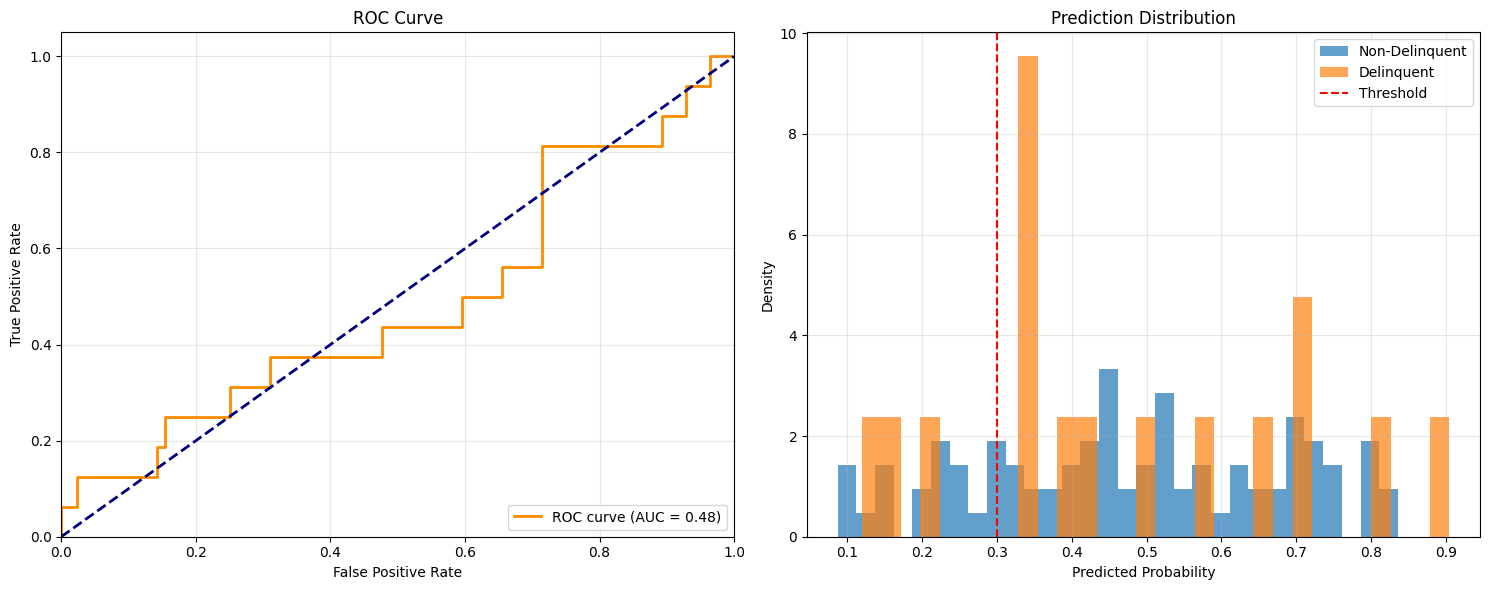

In [12]:
def plot_predictions(self, y_true, y_pred_proba, threshold=0.3):
    """
    Plot model predictions against true values.

    Args:
        y_true (np.ndarray): True target values.
        y_pred_proba (np.ndarray): Predicted probabilities.
        threshold (float): Classification threshold. Default: 0.3.
    """
    plt.style.use('default')
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend(loc="lower right")
    axes[0].grid(True, alpha=0.3)
    
    # Prediction Distribution
    axes[1].hist(y_pred_proba[y_true == 0], bins=30, alpha=0.7, label='Non-Delinquent', density=True)
    axes[1].hist(y_pred_proba[y_true == 1], bins=30, alpha=0.7, label='Delinquent', density=True)
    axes[1].axvline(x=threshold, color='red', linestyle='--', label='Threshold')
    axes[1].set_xlabel('Predicted Probability')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Prediction Distribution')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Add method to class
DelinquencyPredictorLR.plot_predictions = plot_predictions

# Plot predictions
predictor_lr.plot_predictions(y_test, y_pred_proba, threshold=0.3)


FEATURE IMPORTANCE ANALYSIS
X_scaled shape: (100, 31)
Feature names length: 31
Permutation importance length: 31
Top 10 Most Important Features:
                 feature  importance       std
30           Emp_retired    0.019420  0.011490
12               Month_5    0.013244  0.007616
8                Month_1    0.012500  0.038972
11               Month_4    0.010045  0.037635
2           Credit_Score    0.007515  0.001390
17  Location_Los Angeles    0.007217  0.012723
18     Location_New York    0.006548  0.014342
10               Month_3    0.005506  0.002666
27     Emp_Self-employed    0.004911  0.004212
28        Emp_Unemployed    0.002902  0.002753


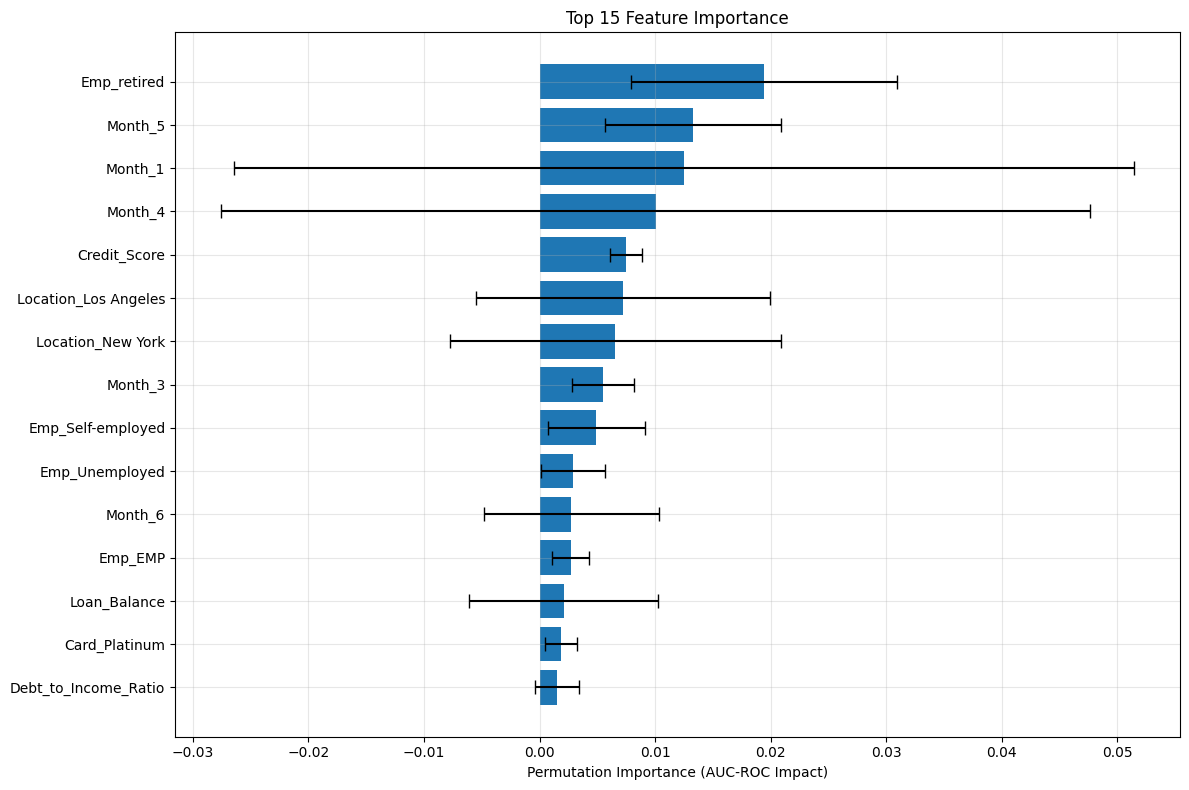

In [13]:
def feature_importance_analysis(self, X, y, feature_names):
    """
    Compute and visualize feature importance using permutation importance.

    Args:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target array.
        feature_names (list): List of feature names.

    Returns:
        pd.DataFrame: DataFrame with features and their importance scores.
    """
    print(f"\n{'='*50}")
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*50)
    
    X_scaled = self.scaler.transform(X)
    
    print(f"X_scaled shape: {X_scaled.shape}")
    print(f"Feature names length: {len(feature_names)}")
    
    # Compute permutation importance
    perm_importance = permutation_importance(
        self.model, X_scaled, y,
        scoring='roc_auc',
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    
    print(f"Permutation importance length: {len(perm_importance.importances_mean)}")
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    print(importance_df.head(10))
    
    # Plot permutation importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'], xerr=top_features['std'], capsize=5)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Permutation Importance (AUC-ROC Impact)')
    plt.title('Top 15 Feature Importance')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Add method to class
DelinquencyPredictorLR.feature_importance_analysis = feature_importance_analysis

# Run feature importance analysis
importance_df = predictor_lr.feature_importance_analysis(X_test, y_test, predictor_lr.feature_names)

In [14]:
def predict_single_sample(self, sample_data, threshold=0.3):
    """
    Predict delinquency for a single sample.

    Args:
        sample_data (dict): Dictionary with feature values for a single sample.
        threshold (float): Classification threshold. Default: 0.3.

    Returns:
        float: Predicted probability.
    """
    sample_df = pd.DataFrame([sample_data])
    
    for col, encoder in self.label_encoders.items():
        if col in sample_df.columns:
            sample_df[col] = encoder.transform(sample_df[col])
    
    sample_df = pd.get_dummies(sample_df, columns=['Location', 'Credit_Card_Type', 'Employment_Status'], prefix=['Location', 'Card', 'Emp'])
    for col in self.feature_names:
        if col not in sample_df.columns:
            sample_df[col] = 0
    sample_df = sample_df[self.feature_names]
    
    sample_scaled = self.scaler.transform(sample_df)
    
    prediction = self.model.predict_proba(sample_scaled)[:, 1][0]
    
    return prediction

# Add method to class
DelinquencyPredictorLR.predict_single_sample = predict_single_sample

# Example prediction
example_data = {
    'Age': 35,
    'Income': 50000,
    'Credit_Score': 650,
    'Credit_Utilization': 0.3,
    'Missed_Payments': 0,
    'Loan_Balance': 15000,
    'Debt_to_Income_Ratio': 0.3,
    'Employment_Status': 'Employed',
    'Account_Tenure': 5,
    'Credit_Card_Type': 'Standard',
    'Location': 'Chicago',
    'Month_1': 'On-time',
    'Month_2': 'On-time',
    'Month_3': 'On-time',
    'Month_4': 'On-time',
    'Month_5': 'On-time',
    'Month_6': 'On-time'
}

prediction = predictor_lr.predict_single_sample(example_data, threshold=0.3)
print(f"Example prediction: {prediction:.4f}")
print(f"Classification: {'Delinquent' if prediction > 0.3 else 'Not Delinquent'}")

Example prediction: 0.3850
Classification: Delinquent


In [16]:
def main():
    """
    Main function to run the delinquency prediction pipeline.
    """
    print("="*60)
    print("    DELINQUENCY PREDICTION LOGISTIC REGRESSION")
    print("="*60)
    
    task_type = 'classification'
    predictor_lr = DelinquencyPredictorLR(task_type=task_type)
    
    data = pd.read_csv('Delinquency_prediction_dataset.csv')  # Update path
    X, y = predictor_lr.load_and_preprocess_data(data=data)
    
    history, X_train, X_test, y_train, y_test = predictor_lr.train_model(X, y, test_size=0.2, use_smote=True)
    
    metrics, y_pred_proba = predictor_lr.evaluate_model(X_test, y_test, threshold=0.3)
    
    predictor_lr.plot_training_history(history)
    predictor_lr.plot_predictions(y_test, y_pred_proba, threshold=0.3)
    
    importance_df = predictor_lr.feature_importance_analysis(X_test, y_test, predictor_lr.feature_names)
    
    predictor_lr.save_model("delinquency_model_lr.pkl")
    
    print(f"\n{'='*50}")
    print("EXAMPLE PREDICTION")
    print("="*50)
    
    example_data = {
        'Age': 35,
        'Income': 50000,
        'Credit_Score': 650,
        'Credit_Utilization': 0.3,
        'Missed_Payments': 0,
        'Loan_Balance': 15000,
        'Debt_to_Income_Ratio': 0.3,
        'Employment_Status': 'Employed',
        'Account_Tenure': 5,
        'Credit_Card_Type': 'Standard',
        'Location': 'Chicago',
        'Month_1': 'On-time',
        'Month_2': 'On-time',
        'Month_3': 'On-time',
        'Month_4': 'On-time',
        'Month_5': 'On-time',
        'Month_6': 'On-time'
    }
    
    prediction = predictor_lr.predict_single_sample(example_data, threshold=0.3)
    print(f"Example prediction: {prediction:.4f}")
    print(f"Classification: {'Delinquent' if prediction > 0.3 else 'Not Delinquent'}")

# Run main (optional)
# main()